In [1]:
# ============================================
# A-1 : 기본 세팅 (고정) 
# ============================================

import os
import time
import random
from pathlib import Path
from typing import List, Tuple

import numpy as np
import nibabel as nib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.ndimage import distance_transform_edt   # centerline distance map
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# 디바이스 설정
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

print("DEVICE:", DEVICE)

DEVICE: mps


In [3]:
# ============================================
# A-2. 데이터 경로 & split 파일 읽기 & 데이터 로딩 (고정)
# ============================================

# ----- 데이터 / split 경로 -----
DATA_ROOT = Path("/Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2")
SPLIT_DIR = DATA_ROOT / "splits"

CT_NAME        = "ct.nii.gz"
MASK_NAME      = "whole_artery_cleaned.nii.gz"
CENTERLINE_NAME = "centerline_v1.nii.gz"

# split 파일에서 케이스 ID 읽기 함수
def read_split_ids(split_dir: Path, split_name: str) -> List[str]:
    path = split_dir / f"{split_name}.txt"
    if not path.exists():
        raise FileNotFoundError(f"{path} not found")

    ids = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                ids.append(line)
    return ids

# 케이스 ID 리스트로 분할 생성 
train_ids = read_split_ids(SPLIT_DIR, "train")
val_ids   = read_split_ids(SPLIT_DIR, "val")
test_ids  = read_split_ids(SPLIT_DIR, "test")

print("Train(ex):", train_ids[:3], "total case :", len(train_ids))
print("Val  (ex):", val_ids[:3], "total case :", len(val_ids))
print("Test (ex):", test_ids[:3], "total case :", len(test_ids))


# 케이스 ID 리스트로 케이스 디렉토리 경로 리스트 생성 함수
def get_case_dirs(data_root: Path, ids: List[str]):
    out = []
    for cid in ids:
        cdir = data_root / cid
        if cdir.is_dir():
            out.append(cdir)
    return out

# 케이스 디렉토리 경로 리스트 생성
train_case_dirs = get_case_dirs(DATA_ROOT, train_ids)
val_case_dirs = get_case_dirs(DATA_ROOT, val_ids)
test_case_dirs = get_case_dirs(DATA_ROOT, test_ids)

print("train_case_dirs (ex):", train_case_dirs[:1], "train_case_dirs : " ,len(train_case_dirs))
print("val_case_dirs   (ex):", val_case_dirs[:1], "val_case_dirs : " ,len(val_case_dirs))
print("test_case_dirs  (ex):", test_case_dirs[:1], "test_case_dirs : " ,len(test_case_dirs))

# 데이터 로딩 함수
def load_case(case_dir: Path,
              ct_name: str = CT_NAME,
              mask_name: str = MASK_NAME,
              center_name: str = CENTERLINE_NAME):
    """ct / mask / centerline NIfTI를 모두 읽어옴."""
    ct_path   = case_dir / ct_name
    mask_path = case_dir / mask_name
    cl_path  = case_dir / center_name

    if not ct_path.exists():   raise FileNotFoundError(ct_path)
    if not mask_path.exists(): raise FileNotFoundError(mask_path)
    if not cl_path.exists():  raise FileNotFoundError(cl_path)

    ct_nii   = nib.load(str(ct_path))
    mask_nii = nib.load(str(mask_path))
    cl_nii  = nib.load(str(cl_path))

    ct   = ct_nii.get_fdata().astype(np.float32)
    mask = mask_nii.get_fdata().astype(np.float32)
    cl  = cl_nii.get_fdata().astype(np.float32)

    assert ct.shape == mask.shape == cl.shape, f"shape mismatch in {case_dir.name}"

    return ct, mask, cl



Train(ex): ['01018ug_73', '01011ug_506', '01015ug_89'] total case : 69
Val  (ex): ['01018ug_86', '01018ug_72', '01018ug_87'] total case : 14
Test (ex): ['01010ug_136', '01010ug_170', '01011ug_528'] total case : 16
train_case_dirs (ex): [PosixPath('/Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2/01018ug_73')] train_case_dirs :  69
val_case_dirs   (ex): [PosixPath('/Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2/01018ug_86')] val_case_dirs :  14
test_case_dirs  (ex): [PosixPath('/Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2/01010ug_136')] test_case_dirs :  16


In [4]:
# ============================================
# B-1. 공통 유틸함수 (CT normalization, patch 추출)
# ============================================

############### CT 정규화 함수
'''
ct: 원본 CT 볼륨
hu_min: 윈도우 하한 (기본: -200 연부조직)
hu_max: 윈도우 상한 (기본: 300 조영혈관)
'''
def normalize_ct(ct: np.ndarray, hu_min=-200.0, hu_max=300.0) -> np.ndarray:
    ct_windowed = np.clip(ct, hu_min, hu_max)
    ct_normalized = (ct_windowed - hu_min) / (hu_max - hu_min)
    return ct_normalized.astype(np.float32)

############### 3D 패치 추출 함수

    """
    volume에서 center를 중심으로 하는 3D 패치 추출.    
    항상 size=patch_size 인 패치를 반환.
    boundary 벗어나면 zero-padding 자동 처리.
    """

def get_patch(volume: np.ndarray,
              center: tuple[int, int, int],
              patch_size: int | tuple[int, int, int]):
    
    # 초기설정
    D, H, W = volume.shape
    if isinstance(patch_size, int):
        pd = ph = pw = patch_size
    else:
        pd, ph, pw = patch_size

    zc, yc, xc = center     # 중심 좌표
    
    # 반경 계산
    rd, rh, rw = pd // 2, ph // 2, pw // 2
    
    # 패치 배열 (zero initialized)
    patch = np.zeros((pd, ph, pw), dtype=volume.dtype)

    # volume에서 가져올 실제 좌표 범위
    z0 = max(zc - rd, 0)      # 음수 방지
    z1 = min(zc + rd, D)      # 가장자리 제한
    y0 = max(yc - rh, 0)      # 음수 방지
    y1 = min(yc + rh, H)      # 가장자리 제한
    x0 = max(xc - rw, 0)      # 음수 방지
    x1 = min(xc + rw, W)      # 가장자리 제한
    
    # patch 내부 위치
    pz0 = rd - (zc - z0)    # 패치 내 시작 인덱스
    py0 = rh - (yc - y0)    # 패치 내 시작 인덱스
    px0 = rw - (xc - x0)    # 패치 내 시작 인덱스

    # 실제 붙일 부분의 shape
    src = volume[z0:z1, y0:y1, x0:x1] # volume 에서 가능한 부분 추출   
    dz, dy, dx = src.shape

    # zero-initialize 했던 patch에 실제값 넣어주기 (나머지는 0으로 유지=padding)
    patch[pz0:pz0+dz, py0:py0+dy, px0:px0+dx] = src

    return patch

In [5]:
# =========================
# B-2. Centerline 관련 유틸
# =========================

# -----------------------------
# KDTree 생성
# -----------------------------

def build_centerline_kdtree(centerline_vol: np.ndarray):
    """
    centerline_vol > 0 인 좌표들로 KDTree 생성
    return: (coords, tree)
      - coords: (N,3) array (z, y, x)
    """
    coords = np.argwhere(centerline_vol > 0)  # centerline voxel 의 모든 좌표
    if coords.shape[0] == 0:
        raise RuntimeError("Centerline volume is empty.")
    
    # cKDTree(k-Dimensional Tree)
    tree = cKDTree(coords)  # 좌표들 간의 최근접 이웃 검색을 빠르게 수행할 수 있는 자료구조
    return coords, tree

# -----------------------------
# agent가 이동한 좌표 주변 K 개의 centerline 위의 점들의 주성분 방향 계산
# -----------------------------
def estimate_tangent(coords: np.ndarray,
                     tree: cKDTree,
                     pos: tuple,
                     k: int = 7) -> np.ndarray:
    """
    현재 위치 pos 주변의 centerline 점들을 모아서
    PCA(주성분) 기반으로 tangent 방향 추정.
    
    - coords: (N,3) centerline voxel 좌표 (z,y,x)
    - pos   : (z,y,x)
    - k     : 주변 몇 개의 이웃을 볼지 
    """
    pos_arr = np.array(pos, dtype=np.float32)

    # 이웃 k개 찾기
    
    k_use = min(k, coords.shape[0])            # 주변 이웃 개수는 전체 점 개수보다 클 수 없음
    _, idx = tree.query(pos_arr, k_use)        # pos_arr 에서 가장 가까운 k_use 개의 점 인덱스
    neigh = coords[idx]                        # k_use 개의 점 인덱스 의 좌표값 반환

    # 이웃들을 평균 기준으로 중심화 (centered)
    mean = neigh.mean(axis=0, keepdims=True)  # (1,3)
    centered = neigh - mean                   # (k,3)

    # 모든 점이 거의 같은 위치에 있으면 방향 정의가 안 됨
    try:
        _, s, vh = np.linalg.svd(centered, full_matrices=False)  # vh: (3,3)
        
        # 첫 번째 특이값이 너무 작으면 방향이 불명확
        if s[0] < 1e-6:
            return None
            
        # vh[0]은 이미 정규화되어 있음 (SVD의 특성)
        return vh[0].astype(np.float32)        # 첫 번째 행: 주성분 방향
        
    except np.linalg.LinAlgError:
        return None

# -----------------------------
# cos similarity 계산 함수 (이전 위치, action 후 위치, tangent 벡터)
# -----------------------------
def cosine_to_centerline(prev_pos: tuple,
                         new_pos: tuple,
                         tangent_vec: np.ndarray):
    """
    prev_pos -> new_pos 로의 이동 방향과 centerline tangent간 cosine 계산
    """
    # 1. 좌표를 numpy 배열로 변환
    p0 = np.array(prev_pos, dtype=np.float32)
    p1 = np.array(new_pos,  dtype=np.float32)
    
    # 2. [이동 벡터] 이번 턴에 내가 움직인 방향 (나중 위치 - 처음 위치)
    move_vec = p1 - p0

    # 3. 이동 거리 계산 
    mv_norm = np.linalg.norm(move_vec)
    
    # 4. 만약 움직이지 않았다면(거리=0), 유사도는 0입니다
    if mv_norm < 1e-8:
        return 0.0

    # 5. [정규화] 이동 벡터의 길이를 1로 만듭니다. (방향만 비교하기 위해)
    move_vec = move_vec / mv_norm
    
    # 6. 정답 벡터(tangent)도 길이를 1로 만듭니다. (이미 되어있을 테지만 안전장치)
    t = tangent_vec / (np.linalg.norm(tangent_vec) + 1e-8)

    # 7. [내적(Dot Product)] 두 벡터의 코사인 유사도를 구합니다.
    # 결과값 범위: -1.0 ~ 1.0
    # 1.0: 완전 같은 방향 / 0.0: 직각 / -1.0: 완전 반대 방향
    
    cos_val = float(np.dot(move_vec, t))
    return cos_val  # -1 ~ +1

# -----------------------------
# 이동 점(point)과 centerline 중 가장 가까운 점 거리
# -----------------------------
def point_to_centerline_distance(pos: tuple,
                                 tree: cKDTree) -> float:
    """
    현재 위치 pos에서 centerline까지의 최소 거리
    pos: (z, y, x)
    """
    pos_arr = np.array(pos, dtype=np.float32)
    dist, _ = tree.query(pos_arr, k=1)
    return float(dist)


# -----------------------------------------
# 이동 벡터(선분)와 centerline 사이 거리
# -----------------------------------------
def segment_to_centerline_distance(prev_pos: tuple,
                                   new_pos: tuple,
                                   tree: cKDTree,
                                   n_samples: int = 5) -> float:
    """
    prev_pos -> new_pos 로 이동하는 선분을 따라 n_samples 개의 점을 찍어서
    각 점에서 centerline까지의 거리 중 최소값을 리턴.

    - prev_pos, new_pos: (z, y, x)
    - 실제로는 "이동 궤적 전체가 centerline에서 얼마나 떨어져 있는지"를 보고 싶을 때 사용.
    """
    p0 = np.array(prev_pos, dtype=np.float32)
    p1 = np.array(new_pos,  dtype=np.float32)

    # 선분 위의 sampling (0~1 사이 균등)
    ts = np.linspace(0.0, 1.0, n_samples)
    min_dist = float("inf")

    for t in ts:
        p = (1.0 - t) * p0 + t * p1
        dist, _ = tree.query(p, k=1)
        if dist < min_dist:
            min_dist = float(dist)

    return float(min_dist)

In [6]:
# ============================================
# B-3. 공통 시각화함수  
# ============================================

def plot_trajectory_3d(centerline_vol, traj, case_name, save_path=None):
    """
    centerline_vol : (D,H,W) centerline mask (0/1)
    traj           : (T,3) array of (z,y,x)
    case_name      : str
    save_path      : if provided, PNG 저장
    """
    # centerline coords
    cl_coords = np.argwhere(centerline_vol > 0)

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    # centerline
    ax.scatter(
        cl_coords[:,2],  # x
        cl_coords[:,1],  # y
        cl_coords[:,0],  # z
        c='skyblue', s=3, alpha=0.3, label="centerline"
    )

    # traj
    traj = np.array(traj)
    ax.plot(
        traj[:,2], traj[:,1], traj[:,0],
        c='red', linewidth=3, label="trajectory"
    )

    # start / end
    ax.scatter(traj[0,2], traj[0,1], traj[0,0], c='green', s=80, label="start")
    ax.scatter(traj[-1,2], traj[-1,1], traj[-1,0], c='yellow', s=80, label="end")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title(f"3D Trajectory vs Centerline | {case_name}")
    ax.legend()

    # view angle
    ax.view_init(elev=30, azim=-60)

    if save_path is not None:
        plt.tight_layout()
        plt.savefig(save_path, dpi=150)
        plt.close()
    else:
        plt.show()

## Test 07

In [ ]:
# ============================================
# C-1. 강화학습 환경 (action space = 26, reward : direction + distance + revisit penalty)
# ============================================

import math
import random
import numpy as np
from pathlib import Path
from typing import Sequence
from scipy.ndimage import distance_transform_edt

# =========================================
# 환경 설정 클래스 
# ==========================================
 
"""
    3D CT 혈관 추적용 환경 (6 방향: ±z, ±y, ±x)
    
    state  : (2, patch, patch, patch)
             - ch0 : 정규화된 CT patch
             - ch1 : visited patch (이미 지나간 voxel = 1.0 + brush_radius)
    action : (총 26개)
             0: +z, 1: -z, 2: +y, 3: -y, 4: +x, 5: -x
    reward :
      - volume 밖 : 패널티 (out_penalty)
      - vessel 내부 이동 시   :
          * 방향 보상 r_dir   = |cos(move, tangent)|
          * 거리 보상 r_dist  = exp(-dist^2 / (2 σ^2))
          * 새 voxel 방문 X   : revisit_penalty 추가
"""
MAX_STEPS = 1000
BRUSH_RADIUS = 2
PATCH_SIZE = (32, 32, 32)


class CTVesselEnv5:
    def __init__(
        self,
        data_root: Path | str | None = None,
        case_dirs: Sequence[Path] | None = None,
        patch_size: int = PATCH_SIZE,
        max_steps: int = MAX_STEPS,
        brush_radius: int = BRUSH_RADIUS,
        mode: str = "train",
        split_ratio: float = 0.8,
        sigma_dist: float = 5.0,
        w_dir: float = 0.3,
        w_dist: float = 0.7,
        revisit_penalty: float = -0.8,
        out_penalty: float = -1.0,
        augment: bool = True,
    ):       
        # -------- 공통 하이퍼파라미터 --------
        self.patch_size = patch_size
        self.max_steps = max_steps
        self.brush_radius = brush_radius

        self.sigma_dist = sigma_dist
        self.w_dir = w_dir
        self.w_dist = w_dist
        self.revisit_penalty = revisit_penalty
        self.out_penalty = out_penalty
        self.augment = augment

        # ---------- action 정의 (26 방향: 3x3x3 이웃, 자기 자신 제외) ----------
        # action: 0 ~ 25
        self.deltas = []
        for dz in (-1, 0, 1):
            for dy in (-1, 0, 1):
                for dx in (-1, 0, 1):
                    if dz == 0 and dy == 0 and dx == 0:
                        continue  # (0,0,0)은 제외
                    self.deltas.append((dz, dy, dx))
        self.deltas = np.array(self.deltas, dtype=int)
        self.n_actions = len(self.deltas)  # 26
        
        # ---------- case 목록 설정 ----------
        if case_dirs is not None:
            # 이미 train/val split 해서 list[Path]로 넘겨준 경우 (지금 네 셋업)
            self.case_dirs = [Path(p) for p in case_dirs]
            if not self.case_dirs:
                raise RuntimeError("case_dirs is empty.")
            self.data_root = self.case_dirs[0].parent
            print(f"[Env5] Using explicit case_dirs: {len(self.case_dirs)} cases.")
        else:
            # 옛날 스타일: data_root 아래에서 split_ratio로 나눔
            if data_root is None:
                raise ValueError("Either data_root or case_dirs must be provided.")

            self.data_root = Path(data_root)
            all_cases = sorted([p for p in self.data_root.iterdir() if p.is_dir()])
            if not all_cases:
                raise RuntimeError(f"No case folders under {self.data_root}")

            split_idx = int(len(all_cases) * split_ratio)
            if mode == "train":
                self.case_dirs = all_cases[:split_idx]
                print(f"[Train Env5] {len(self.case_dirs)} cases used.")
            else:
                self.case_dirs = all_cases[split_idx:]
                print(f"[Eval Env5] {len(self.case_dirs)} cases used.")

            if not self.case_dirs:
                raise RuntimeError(f"No cases assigned for mode={mode}")

        # ---------- 에피소드별 상태 변수 ----------
        self.ct = None
        self.mask = None
        self.centerline = None
        self.ct_norm = None
        self.visited_vol = None

        # 거리/centerline 관련 맵
        self.dist_map = None           # centerline까지의 voxel 거리
        self.centerline_coords = None  # (N,3) 좌표
        self.centerline_tree = None    # KDTree

        self.D = self.H = self.W = None
        self.pos = None                # 현재 위치 (z,y,x)
        self.step_count = 0
        self.current_case_dir = None

    # =====================================================
    # Data augmentation (안전한 범위 내에서만)
    # =====================================================
      
    def _safe_augment(self, ct, mask, cl):
        
        """
        spacing 왜곡이 심한 transpose는 쓰지 않고,
        z축 고정 상태에서 (y,x) 평면 내 회전/flip만 적용.
        """
        
        # (1) axial plane 회전 (0,90,180,270도)
        k = random.choice([0, 1, 2, 3])
        if k != 0:
            ct = np.rot90(ct, k, axes=(1, 2))
            mask = np.rot90(mask, k, axes=(1, 2))
            cl = np.rot90(cl, k, axes=(1, 2))

        '''
        # (2) 좌우 flip (y축)
        if random.random() < 0.5:
            ct = np.flip(ct, axis=1)
            mask = np.flip(mask, axis=1)
            cl = np.flip(cl, axis=1)

        # (3) 상하 flip (x축)
        if random.random() < 0.5:
            ct = np.flip(ct, axis=2)
            mask = np.flip(mask, axis=2)
            cl = np.flip(cl, axis=2)
        '''
        
        return ct, mask, cl

    # =====================================================
    # 케이스 로드 및 전처리
    # ====================================================
    def _load_random_case(self):
        """학습/평가용 케이스 중 하나를 랜덤 로드"""
        while True:
            case_dir = random.choice(self.case_dirs)
            try:
                ct, mask, cl = load_case(case_dir)
            except Exception as e:
                print(f"[WARN] load failed at {case_dir.name}: {e}")
                continue

            if mask.sum() == 0:
                # vessel mask 없는 케이스는 스킵
                print(f"[WARN] empty vessel mask: {case_dir.name}")
                continue
            if cl.sum() == 0:
                # centerline 없는 케이스는 스킵
                print(f"[WARN] empty centerline: {case_dir.name}")
                continue

            # ✅ train일 때만 augmentation 적용
            if self.augment:
                ct, mask, cl = self._safe_augment(ct, mask, cl)

            self.ct = ct.astype(np.float32)
            self.mask = (mask > 0.5).astype(np.uint8)
            self.centerline = (cl > 0).astype(np.uint8)              # centerline은 끊어지면 큰일 남. threshold = 0 로 해야 안전
            self.ct_norm = normalize_ct(self.ct)
            self.visited_vol = np.zeros_like(self.mask, dtype=np.float32)    # visited_vol (0.0 초기화)

            self.D, self.H, self.W = self.ct.shape
            self.current_case_dir = case_dir

            # centerline KDTree & 좌표
            self.centerline_coords, self.centerline_tree = build_centerline_kdtree(self.centerline)
            
            # centerline까지의 voxel 거리 맵 (DT)   # centerline==1 인 곳에서는 0, 멀어질수록 증가
            self.dist_map = distance_transform_edt(1 - self.centerline)

            break  # 성공적으로 로드했으면 종료
            
    # ====================================================
    # 시작 위치: centerline 위에서 랜덤 샘플링
    # ====================================================
    def _sample_start_pos(self):
        idx = np.random.randint(len(self.centerline_coords))
        return tuple(self.centerline_coords[idx])

    # ====================================================
    # 현재 위치를 중심으로 2채널 패치 추출
    # ====================================================
    def _get_state(self):
        ct_patch = get_patch(self.ct_norm, self.pos, self.patch_size)
        vis_patch = get_patch(self.visited_vol, self.pos, self.patch_size)
        state = np.stack([ct_patch, vis_patch], axis=0).astype(np.float32)
        return state
    
    # =====================================================
    # 26방향 중 하나로 1 voxel 이동
    # =====================================================
    def _move(self, z, y, x, action: int):
        dz, dy, dx = self.deltas[action]
        return z + dz, y + dy, x + dx
    
    # =====================================================
    # 현재 위치에서 brush 적용 (방문 처리)
    # =====================================================
    def _apply_brush(self, center_pos):
        '''
        붓 반경(brush_radius) 내에서:
          - vessel mask == 1 이면서
          - visited_vol == 0 인 위치만 1로 채움
        return: 새로 방문한 voxel 개수
        '''
        z, y, x = center_pos
        r = self.brush_radius

        z_min, z_max = max(0, z - r), min(self.D, z + r + 1)
        y_min, y_max = max(0, y - r), min(self.H, y + r + 1)
        x_min, x_max = max(0, x - r), min(self.W, x + r + 1)

        target = self.mask[z_min:z_max, y_min:y_max, x_min:x_max]           # [center position + brush 영역] 중 vessel mask 에 해당하는 곳 --- a
        visited = self.visited_vol[z_min:z_max, y_min:y_max, x_min:x_max]   # [center position + brush 영역] 중 visited_vol 에 해당하는 곳 --- b

        newly = (target == 1) & (visited == 0)                              # a 이면서 b 가 아닌 곳 (새로 방문한 곳)
        new_count = int(newly.sum())                                        # 새로 방문한 voxel 개수                               

        # 실제 방문 표시 업데이트
        self.visited_vol[z_min:z_max, y_min:y_max, x_min:x_max][newly] = 1.0    # visited_vol 에서 newly 인 곳을 1.0 으로 채움
        
        return new_count

    # =====================================================
    # 새 에피소드 시작
    # =====================================================
    def reset(self, seed: int | None = None):
        
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        self._load_random_case()
        self.pos = self._sample_start_pos()
        self.step_count = 0

        # 시작 위치 주변도 방문 처리
        self._apply_brush(self.pos)

        state = self._get_state()
        info = {
            "pos": self.pos,
            "case": self.current_case_dir.name,
            "reason": "reset",
        }
        return state, info

    # =====================================================
    # 한 step 진행 
    # =====================================================
    def step(self, action: int):
        """
        한 step 진행:
          - action에 따라 위치 이동
          - 보상 계산
          - done 여부 판단
        """
        z, y, x = self.pos
        nz, ny, nx = self._move(z, y, x, action)

        # 기본 info
        info = {
            "case": self.current_case_dir.name,
        }
        # ---------- 보상 및 종료 조건 판단 ----------
        # ---------- 1) volume 밖으로 나가면 (out_penalty + 즉시 종료 ) ----------
        if not (0 <= nz < self.D and 0 <= ny < self.H and 0 <= nx < self.W):
            reward = self.out_penalty
            done = True                             # episode 종료
            info["pos"] = self.pos                  # 마지막 유효 위치
            info["reason"] = "out_of_volume"
            return self._get_state(), reward, done, False, info

        # ---------- 2) vessel mask 밖 (out_penalty + 즉시 종료 ) ----------
        if self.mask[nz, ny, nx] == 0:
            reward = self.out_penalty
            done = True                             # episode 종료
            self.pos = (nz, ny, nx)
            info["pos"] = self.pos                  # 마지막 유효 위치
            info["reason"] = "out_of_vessel"
            return self._get_state(), reward, done, False, info

        # ---------- 3) vessel 내부: 보상 계산 ----------
        
        # (A) 방향 보상: centerline tangent와 이동 방향 간 cos
        tangent = estimate_tangent(
            self.centerline_coords,
            self.centerline_tree,
            (nz, ny, nx),
        )
        if tangent is not None:
            cos_val = cosine_to_centerline((z, y, x), (nz, ny, nx), tangent)
            r_dir = abs(cos_val)  # centerline 방향이기만 하면 되므로 절대값 : 축 방향이면 +1 또는 -1 근처가 되므로 절댓값 사용 (r_dir: 0~1)
        else:
            r_dir = 0.0  # 방향 불명시 0
        
        # (B) 거리 보상: centerline에 가까울수록 1에 가까움
        dist = float(self.dist_map[nz, ny, nx])
        r_dist = math.exp(-(dist ** 2) / (2 * (self.sigma_dist ** 2)))  # 0~1

        # (C) 탐험 보상 : 새 voxel을 방문했는지 확인
        new_voxels = self._apply_brush((nz, ny, nx))
                
        if new_voxels == 0:
            explore_reward = self.revisit_penalty 
        elif new_voxels < 5:
            explore_reward = 0.1  # 작은 보너스
        elif new_voxels < 20:
            explore_reward = 0.3  # 중간 보너스
        else:
            explore_reward = 0.5  # 큰 보너스 (굵은 혈관)
        
        # 보상 총합 ([방향 가중치 * 방향 cosine] + [거리가중치 * centerline 과 거리] 반영)
        reward = self.w_dir * r_dir + self.w_dist * r_dist + explore_reward

        # 상태 업데이트
        self.pos = (nz, ny, nx)
        self.step_count += 1
        done = (self.step_count >= self.max_steps)

        info["pos"] = self.pos
        info["reason"] = "normal" if not done else "max_steps"

        return self._get_state(), reward, done, False, info

In [ ]:
# ============================================================
# C-2. 3D CNN Q-network (26 actions) + ReplayBuffer + train_step
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random


# ============================================================
# 3D CNN Q-Network (26-actions)
# ============================================================

class CnnQNet(nn.Module):
    """
    Input state:  (2, 32, 32, 32)
      - ch0: normalized CT patch
      - ch1: visited patch

    Output Q-values: (n_actions,)  # 기본 26
    """
    def __init__(self, in_channels=2, n_actions=26):
        super().__init__()
        self.n_actions = n_actions

        # -------- 3D CNN Encoder -------- #
        self.conv = nn.Sequential(
            # (B,2,32,32,32) -> (B,16,32,32,32)
            nn.Conv3d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),

            # -> (B,32,32,32,32)
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            # -> (B,32,16,16,16)
            nn.MaxPool3d(2),

            # -> (B,64,16,16,16)
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            # -> (B,64,16,16,16)
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            # -> (B,64,8,8,8)
            nn.MaxPool3d(2),
        )

        # -------- Fully Connected Head -------- #
        self.fc = nn.Sequential(
            nn.Linear(64 * 8 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, self.n_actions)   # n_actions 출력
        )

    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)  # flatten
        q = self.fc(h)
        return q

    @torch.no_grad()
    def sample_action(self, state, epsilon=0.1):
        """
        Epsilon-greedy action selection
        state: numpy array (2,32,32,32)
        """
        if random.random() < epsilon:
            # 0 ~ n_actions-1 중 랜덤
            return random.randint(0, self.n_actions - 1)

        s = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        q = self.forward(s)  # (1, n_actions)
        return int(torch.argmax(q, dim=1).item())
    
    
    
# ============================================================
# Replay Buffer
# ============================================================

class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, ns, done):
        """
        s   : (2,32,32,32)
        a   : int
        r   : float
        ns  : (2,32,32,32)
        done: bool
        """
        self.buffer.append((s, a, r, ns, done))

    def sample(self, batch_size=64):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        s, a, r, ns, done = zip(*(self.buffer[i] for i in indices))

        return (
            np.array(s, dtype=np.float32),       # (B,2,32,32,32)
            np.array(a, dtype=np.int64),         # (B,)
            np.array(r, dtype=np.float32),       # (B,)
            np.array(ns, dtype=np.float32),      # (B,2,32,32,32)
            np.array(done, dtype=np.float32),    # (B,)
        )

    def __len__(self):
        return len(self.buffer)


In [ ]:
# ============================================================
# 📌 최적화된 DQN 학습 루프 (6방향 + centerline reward 전제)
#   - step 기반 epsilon decay
#   - 충분한 replay warm-up
#   - target network 느리게 동기화
#   - reward clipping
#   - best model & 정기 checkpoint 저장
#   - reward curve 저장
# ============================================================

import os
import time
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

def train_dqn(
    env,
    num_episodes=1000,
    max_steps_per_ep=1000,
    batch_size=128,
    gamma=0.99,
    lr=1e-3,
    epsilon_start=1.0,
    epsilon_end=0.1,
    epsilon_decay_steps=30000,   # 글로벌 step 기준으로 천천히 감소
    replay_capacity= 50000,
    replay_warmup = 3000,          # 이만큼 쌓이기 전까지는 학습 안 함
    target_update_steps= 2000,    # 이 step마다 target_net 동기화
    ckpt_dir= "test07_checkpoints",
    ckpt_every_ep= 50,           # 몇 에피소드마다 weight 저장할지
    reward_clip_min=-2.0,
    reward_clip_max=+4.0,
    max_grad_norm=5.0,
):
    os.makedirs(ckpt_dir, exist_ok=True)
    n_actions = getattr(env, "n_actions", 26)  # 혹시 없으면 기본 26
    
    
    # --- Q-network & Target-network 준비 ---
    q_net      = CnnQNet(in_channels=2, n_actions=n_actions).to(DEVICE)
    target_net = CnnQNet(in_channels=2, n_actions=n_actions).to(DEVICE)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    buffer    = ReplayBuffer(capacity=replay_capacity)

    global_step = 0
    reward_hist = []

    best_avg10 = -1e9
    best_ckpt_path = os.path.join(ckpt_dir, "best_model.pth")

    print(">>> Training DQN started...")
    t0 = time.time()

    for ep in range(1, num_episodes + 1):
        state, info = env.reset()
        total_reward = 0.0

        for step in range(max_steps_per_ep):

            # -------------------------
            # 1) epsilon (탐색률) 업데이트
            #    step 기반 지수 감소: 큰 step 수에서 천천히 줄어들도록
            # -------------------------
            eps = epsilon_end + (epsilon_start - epsilon_end) * \
                  np.exp(-1.0 * global_step / epsilon_decay_steps)

            # -------------------------
            # 2) 행동 선택 (eps-greedy)
            # -------------------------
            action = q_net.sample_action(state, eps)

            # -------------------------
            # 3) 한 step 진행
            # -------------------------
            next_state, reward, done, _, info2 = env.step(action)

            # 🔹 reward clipping (너무 큰 값/작은 값 방지)
            reward_clipped = float(np.clip(reward, reward_clip_min, reward_clip_max))

            # done을 float(0 or 1)로 저장 (target 계산에서 사용)
            done_float = 1.0 if done else 0.0

            # Replay buffer에 transition push
            buffer.push(state, action, reward_clipped, next_state, done_float)

            state = next_state
            total_reward += reward_clipped
            global_step += 1

            # -------------------------
            # 4) Replay warm-up 이후에만 학습 시작
            # -------------------------
            if len(buffer) >= replay_warmup and len(buffer) >= batch_size:
                # 샘플링
                s, a, r, ns, d = buffer.sample(batch_size)

                s_t  = torch.from_numpy(s).to(DEVICE)          # (B, 2, 32, 32, 32)
                a_t  = torch.from_numpy(a).to(DEVICE)          # (B,)
                r_t  = torch.from_numpy(r).to(DEVICE)          # (B,)
                ns_t = torch.from_numpy(ns).to(DEVICE)         # (B, 2, 32, 32, 32)
                d_t  = torch.from_numpy(d).to(DEVICE)          # (B,)

                # 현재 Q(s, a)
                q_all = q_net(s_t)                             # (B, 6)
                q_sa  = q_all.gather(1, a_t.unsqueeze(1)).squeeze(1)  # (B,)

                # 타겟 Q 계산 (DQN: max_a' Q_target(s', a'))
                with torch.no_grad():
                    q_next_all = target_net(ns_t)              # (B, 6)
                    q_next_max = q_next_all.max(dim=1)[0]      # (B,)
                    target = r_t + gamma * q_next_max * (1.0 - d_t)

                loss = F.smooth_l1_loss(q_sa, target)

                optimizer.zero_grad()
                loss.backward()

                # 선택 사항: gradient clipping (폭주 방지)
                torch.nn.utils.clip_grad_norm_(q_net.parameters(), max_grad_norm)

                optimizer.step()

            # -------------------------
            # 5) Target network 주기적 동기화
            # -------------------------
            if global_step > 0 and global_step % target_update_steps == 0:
                target_net.load_state_dict(q_net.state_dict())
                # print(f"[Step {global_step}] target_net updated.")

            if done:
                break

        # -------------------------
        # 6) Episode 끝났을 때 로그 기록
        # -------------------------
        reward_hist.append(total_reward)

        if ep % 10 == 0:
            avg10 = float(np.mean(reward_hist[-10:]))
            elapsed = time.time() - t0
            print(f"[Ep {ep:04d}] "
                  f"reward={total_reward:7.2f} (avg10={avg10:7.2f}), "
                  f"steps={step+1:4d}, eps={eps:0.2f}, "
                  f"buffer={len(buffer):6d}, case={info['case']}, "
                  f"time={elapsed/60:5.1f} min")

            # best model 갱신
            if avg10 > best_avg10 and len(reward_hist) >= 10:
                best_avg10 = avg10
                torch.save(q_net.state_dict(), best_ckpt_path)
                print(f"   ↳ ✅ best model updated (avg10={best_avg10:.2f})")

        # -------------------------
        # 7) 정기 checkpoint 저장 (에피소드 기준)
        # -------------------------
        if ep % ckpt_every_ep == 0:
            ckpt_path = os.path.join(ckpt_dir, f"ep{ep:04d}.pth")
            torch.save(q_net.state_dict(), ckpt_path)
            print(f"   ↳ 💾 checkpoint saved to {ckpt_path}")

    # -------------------------
    # 8) 학습 종료 후 최종 weight 저장
    # -------------------------
    final_path = os.path.join(ckpt_dir, "test07_final_model.pth")
    torch.save(q_net.state_dict(), final_path)
    print(f"\n>>> Training completed! Final model saved to {final_path}")
    print(f"    Best model (avg10={best_avg10:.2f}) saved to {best_ckpt_path}")

    # -------------------------
    # 9) reward curve 시각화 & 저장
    # -------------------------
    plt.figure(figsize=(8,4))
    plt.plot(reward_hist, label="episode reward")
    if len(reward_hist) >= 10:
        ma = np.convolve(reward_hist, np.ones(10)/10, mode="valid")
        plt.plot(range(9, 9+len(ma)), ma, label="moving avg (10ep)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training Reward Curve")
    plt.legend()
    plt.grid(True)

    curve_path = os.path.join(ckpt_dir, "reward_curve.png")
    plt.tight_layout()
    plt.savefig(curve_path, dpi=150)
    plt.close()
    print(f"📈 Reward curve saved to {curve_path}")

    np.save(os.path.join(ckpt_dir, "reward_hist.npy"), np.array(reward_hist))

    return q_net, target_net, reward_hist

In [24]:
## 학습 시작

# Train env: augmentation ON
env_train = CTVesselEnv5(
    case_dirs=train_case_dirs,
    patch_size=PATCH_SIZE,
    max_steps=MAX_STEPS,
    brush_radius=BRUSH_RADIUS,
    mode="train",
    augment=True,          # ✅ 학습용이니까 켜두기
)

# Val env: augmentation OFF
env_val = CTVesselEnv5(
    case_dirs=val_case_dirs,
    patch_size=PATCH_SIZE,
    max_steps=MAX_STEPS,
    brush_radius=BRUSH_RADIUS,
    mode="val",
    augment=False,         # ✅ 검증/시각화용이니까 끄기
)

[Env5] Using explicit case_dirs: 69 cases.
[Env5] Using explicit case_dirs: 14 cases.


In [ ]:
# ============================================
# D-1. 학습 하이퍼파라미터 설정
# ============================================
NUM_EPISODES      = 1000     # 전체 에피소드 수
MAX_STEPS_PER_EP  = MAX_STEPS  # env에서 쓴 값과 맞추기
BATCH_SIZE        = 64
GAMMA             = 0.99
LR                = 1e-4

EPS_START         = 0.9
EPS_END           = 0.05

CKPT_DIR          = "test07_checkpoints"
LOG_EVERY         = 5       # 몇 에피소드마다 로그 찍을지 (train_dqn 안에서 사용)

In [ ]:
# ============================================
# D-2. 학습 시작
# ============================================

q_net, target_net, reward_hist = train_dqn(
    env              = env_train,
    num_episodes     = NUM_EPISODES,
    max_steps_per_ep = MAX_STEPS_PER_EP,
    batch_size       = BATCH_SIZE,
    gamma            = GAMMA,
    lr               = LR,
    epsilon_start    = EPS_START,
    epsilon_end      = EPS_END,
    ckpt_dir         = CKPT_DIR,
    
)

print("✅ Training finished.")

>>> Training DQN started...
[Ep 0010] reward=  14.70 (avg10=   9.14), steps=  15, eps=0.90, buffer=   121, case=01011ug_514, time=  1.6 min
   ↳ ✅ best model updated (avg10=9.14)
[Ep 0020] reward=  -1.00 (avg10=   2.46), steps=   1, eps=0.90, buffer=   166, case=01018ug_73, time=  3.0 min
[Ep 0030] reward=  -0.19 (avg10=   0.30), steps=   2, eps=0.89, buffer=   188, case=01010ug_5, time=  4.4 min
[Ep 0040] reward=   8.46 (avg10=  11.88), steps=  15, eps=0.89, buffer=   363, case=01010ug_3, time=  6.2 min
   ↳ ✅ best model updated (avg10=11.88)
[Ep 0050] reward=   4.23 (avg10=  14.45), steps=  12, eps=0.88, buffer=   612, case=01011ug_514, time=  7.9 min
   ↳ ✅ best model updated (avg10=14.45)
   ↳ 💾 checkpoint saved to test07_checkpoints/ep0050.pth
[WARN] load failed at 01010ug_11: Error -3 while decompressing data: invalid literal/length code
[Ep 0060] reward=  -1.00 (avg10=   0.05), steps=   1, eps=0.88, buffer=   634, case=01018ug_90, time=  9.4 min
[Ep 0070] reward=  -1.00 (avg10= 

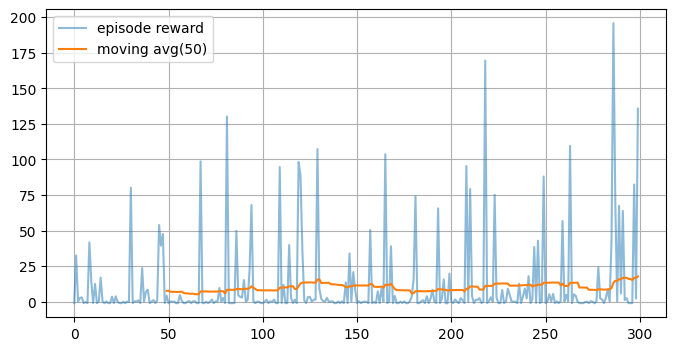

In [27]:
# reward 히스토리 불러와서 시각화
hist = np.load("../results/test07_checkpoints/reward_hist.npy")
plt.figure(figsize=(8,4))
plt.plot(hist, alpha=0.5, label="episode reward")
if len(hist) >= 50:
    ma = np.convolve(hist, np.ones(50)/50, mode="valid")
    plt.plot(range(49, 49+len(ma)), ma, label="moving avg(50)")
plt.legend(); plt.grid(True)

In [28]:
#################### 
# val env에서 greedy 평가
#####################

q_net = CnnQNet(in_channels=2, n_actions=26).to(DEVICE)
state_dict = torch.load("../results/test07_checkpoints/test07_final_model.pth", map_location=DEVICE)
q_net.load_state_dict(state_dict)
q_net.eval()


def rollout_greedy(env, q_net, max_steps=300):
    state, info = env.reset()
    traj = [info["pos"]]
    total_r = 0.0
    reasons = None

    for t in range(max_steps):
        a = q_net.sample_action(state, epsilon=0.0)
        next_state, r, done, _, info2 = env.step(a)
        traj.append(info2["pos"])
        total_r += r
        state = next_state
        if done:
            reasons = info2["reason"]
            break
    return np.array(traj), total_r, reasons


import os
import csv

# 저장 폴더
save_dir = "../results/test07_val_greedy_results"
os.makedirs(save_dir, exist_ok=True)

csv_path = os.path.join(save_dir, "val_results.csv")

# CSV 준비
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["case", "steps", "total_reward", "reason", "png_path"])

print(">>> Running greedy evaluation on ALL val cases ...\n")

results = []

for idx, cdir in enumerate(val_case_dirs):
    # val env에 현재 케이스만 넣기
    env_val.case_dirs = [cdir]

    # rollout
    traj, total_R, reason = rollout_greedy(env_val, q_net, max_steps=300)
    steps = len(traj)
    case_name = cdir.name

    # PNG 저장 경로
    save_path = os.path.join(save_dir, f"{case_name}_traj.png")

    # 3D plot 저장
    plot_trajectory_3d(
        centerline_vol=env_val.centerline,
        traj=traj,
        case_name=f"{case_name}",
        save_path=save_path
    )

    results.append((case_name, steps, total_R, reason, save_path))

    print(f"[{idx+1:02d}/{len(val_case_dirs)}] case={case_name} "
          f"steps={steps}, R={total_R:.2f}, reason={reason}")

# CSV 저장
with open(csv_path, "a", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(results)

print("\n>>> Evaluation finished!")
print(f"Results saved to: {csv_path}")
print(f"Images saved to : {save_dir}")

>>> Running greedy evaluation on ALL val cases ...

[01/14] case=01018ug_86 steps=3, R=-0.22, reason=out_of_vessel
[02/14] case=01018ug_72 steps=2, R=-1.00, reason=out_of_vessel
[03/14] case=01018ug_87 steps=4, R=1.03, reason=out_of_vessel
[04/14] case=01010ug_8 steps=72, R=70.58, reason=out_of_vessel
[05/14] case=01018ug_85 steps=3, R=-0.05, reason=out_of_vessel
[06/14] case=01015ug_92 steps=3, R=0.06, reason=out_of_vessel
[07/14] case=01015ug_97 steps=2, R=-1.00, reason=out_of_vessel
[08/14] case=01010ug_134 steps=4, R=1.23, reason=out_of_vessel
[09/14] case=01010ug_164 steps=3, R=0.29, reason=out_of_vessel
[10/14] case=01011ug_529 steps=4, R=1.16, reason=out_of_vessel
[11/14] case=01018ug_81 steps=74, R=67.86, reason=out_of_vessel
[12/14] case=01018ug_84 steps=9, R=6.99, reason=out_of_vessel
[13/14] case=01011ug_502 steps=21, R=21.37, reason=out_of_vessel
[14/14] case=01010ug_174 steps=2, R=-1.00, reason=out_of_vessel

>>> Evaluation finished!
Results saved to: ../results/test07_val